In [128]:
import numpy as np
import pandas as pd
import math as m
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
%matplotlib inline

# Import data

In [129]:
training_set = pd.read_csv("Training Set.csv")
training_label = pd.read_csv("Training Set Labels.csv")

data = pd.merge(training_set, training_label, how="left", on="id")
print(data.shape)
data.head()

(59400, 41)


,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,3/14/11,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,3/6/13,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2/25/13,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,1/28/13,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,7/13/11,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


# Cleansing & transform

In [130]:
# Drop columns
feature_list = ['date_recorded', 'installer','longitude', 'latitude', 'basin', 'gps_height',
                'region', 'lga', 'extraction_type_group', 'extraction_type_class', 'construction_year', 
                'payment_type', 'water_quality', 'quantity', 'source_type', 'source_class', 'waterpoint_type', 
                'permit', 'status_group']

# if we are using random forest, we don't really need to deal with all the 0s in construction year

data = data[feature_list]
# print(all_data.shape)

In [131]:
# Transform installer
data['installer'] = data['installer'].str.lower()
data['installer_dwe'] = data['installer'].apply(lambda x: 1 if x == 'dwe' else 0)
data['installer_gov'] = data['installer'].str.contains('gov', na=False).astype(int)
data['installer_nan'] = data['installer'].isnull().astype(int)
data['installer_other'] = (data['installer_dwe'] + data['installer_gov'] + data['installer_nan']) * (-1) + 1
data = data.drop('installer', axis=1)

In [132]:
# Transform funder
# Keep the top 10 funders and mark NaN
#funder10 = data.groupby('funder').size().sort_values(ascending=False).index.tolist()[0 : 11]
#other = data['funder'].apply(lambda x: 0)
#for funder in funder10:
#    col = data['funder'].apply(lambda x: 1 if x == funder else 0)
#    other += col
#    data[('funder_' + funder)] = col

#data['funder_nan'] = data['funder'].isnull().astype(int)
#data['funder_other'] = (other + all_data['funder_nan']) * (-1) + 1
#data = data.drop('funder', axis=1)

In [133]:
# Transform datetime
date_recorded = pd.to_datetime(data["date_recorded"])
data['month'] = date_recorded.apply(lambda x: x.month).astype(str)
time_delta = (date_recorded - date_recorded.min()).astype('timedelta64[D]').astype(int) + 1
data["time_difference"] = time_delta
data = data.drop("date_recorded", axis=1)

# Add rain season and dry season
dry = ['6', '7', '8', '9', '10']
data['dry_season'] = data['month'].apply(lambda x: 1 if x in dry else 0)
data['rain_season'] = data['dry_season'].apply(lambda x: 1 if x == 0 else 1)
data = data.drop('month', axis=1)

In [134]:
# Generate dummy
categorical = ['basin', 'region', 'lga', 'extraction_type_group', 'extraction_type_class', 'payment_type',
               'water_quality', 'quantity', 'source_type', 'source_class', 'waterpoint_type', 'permit']

for item in categorical:
    dummy = pd.get_dummies(data[item], prefix=item, dummy_na=True)  # Create one more column indicating data missing
    data = data.join(dummy.ix[:, :])
    data = data.drop(item, axis=1)

In [135]:
# Function for feature transform
def transform(data):
    # Add column "population_0", "gps_height_0" and "amount_tsh_0"
    #data['population_0'] = data['population'].apply(lambda x: 1 if x == 0 else 0)
    #data['gps_height_0'] = data['gps_height'].apply(lambda x: 1 if x == 0 else 0)
    #data['amount_tsh_0'] = data['amount_tsh'].apply(lambda x: 1 if x == 0 else 0)

    # Transform extremely skewed columns "population" and "amount_tsh"
    #data['population'] = data['population'].apply(lambda x: m.log2(x + 1) if x < 5000 else m.log2(5000))
    #data['amount_tsh'] = data['amount_tsh'].apply(lambda x: m.log2(x + 1) if x < 5000 else m.log2(5000))

    # Standardize continuous variables
    continuous = ["longitude", "latitude", "time_difference"]
    scalar = preprocessing.StandardScaler()
    scalar.fit(data[continuous])
    data[continuous] = scalar.transform(data[continuous])
        
    return data


In [136]:
# Transform and split data
data = transform(data)

In [137]:
# K-means clustering for location features
#data = data[data['longitude'] != 0]
#location = data[['longitude', 'latitude', 'gps_height']]
#location = location[location['longitude'] != 0]
#kmeans = KMeans(n_clusters=30, random_state=0).fit(location)
#centroids = kmeans.cluster_centers_

# Create new features that decribes the distance to each centroid
#count = 1
#for centroid in centroids:
#    column_name = 'centroid_' + str(count)
#    count += 1
#    data[column_name] = ((data['longitude'] - centroid[0])**2 + (data['latitude'] - centroid[1])**2 + 
#                         (data['gps_height'] - centroid[2])**2).apply(lambda x: m.sqrt(x))
    
data = data.drop(['gps_height'], axis=1)

In [138]:
train, other = train_test_split(data, test_size=0.6)
cv, test = train_test_split(other, test_size=0.5)

In [139]:
# Remove outliers in training set
train = train[train["longitude"] != 0]

In [140]:
y_train = train['status_group']
x_train = train.drop(['status_group'], axis=1)
y_cv = cv['status_group']
x_cv = cv.drop(['status_group'], axis=1)

In [141]:
y_test = test['status_group']
x_test = test.drop(['status_group'], axis=1)

# Fit model

In [147]:
# Fit logistic regression model
model = LogisticRegression(penalty='l1', C=10, multi_class='ovr')
model.fit(x_train, y_train)
print("Training accuracy: ", model.score(x_train, y_train))
print("Cross validation accuracy: ", model.score(x_cv, y_cv))

Training accuracy:  0.749915824916
Cross validation accuracy:  0.743378226712


In [146]:
# Fit SVM
model = SVC(decision_function_shape='ovr', kernel='rbf')
model.fit(x_train, y_train)
print("Training accuracy: ", model.score(x_train, y_train))
print("Cross validation accuracy: ", model.score(x_cv, y_cv))

Training accuracy:  0.728787878788
Cross validation accuracy:  0.728002244669


In [40]:
# Fit a single decision tree
model = DecisionTreeClassifier(max_features=None, max_depth=20)
model.fit(x_train, y_train)
print("Training accuracy: ", model.score(x_train, y_train))
print("Cross validation accuracy: ", model.score(x_cv, y_cv))

Training accuracy:  0.940480334145
Cross validation accuracy:  0.727861952862


In [145]:
# Fit bagging model
base_model = DecisionTreeClassifier(max_features=None, max_depth=20)
#base_model = LogisticRegression(penalty='l2', C=10, multi_class='ovr')
model = BaggingClassifier(base_estimator=base_model, n_estimators=50)
model.fit(x_train, y_train)
print("Training accuracy: ", model.score(x_train, y_train))
print("Cross validation accuracy: ", modelrf.score(x_cv, y_cv))

Training accuracy:  0.924579124579
Cross validation accuracy:  0.78608305275


In [143]:
# Fit random forest
modelrf = RandomForestClassifier(n_estimators=50, max_depth=20, max_features=None)
modelrf.fit(x_train, y_train)
print("Training accuracy: ", modelrf.score(x_train, y_train))
print("Cross validation accuracy: ", modelrf.score(x_cv, y_cv))

Training accuracy:  0.923569023569
Cross validation accuracy:  0.78608305275


# Plot accuracy against n_estimators

In [91]:
accuracy_cv = np.zeros(100)
accuracy_train = np.zeros(100)
for i in range(1, 101):
    model = RandomForestClassifier(n_estimators=i, max_depth=20, max_features='auto')
    model.fit(x_train, y_train)
    accuracy_cv[i - 1] = model.score(x_cv, y_cv)
    accuracy_train[i - 1] = model.score(x_train, y_train)

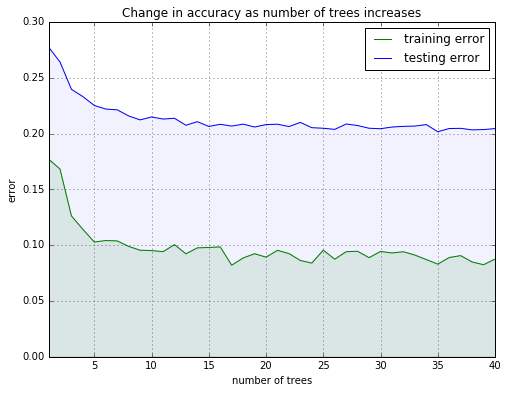

In [95]:
fig = plt.figure(figsize=(8,6))
x = np.linspace(1, 100, 100)
y1 = 1 - accuracy_train
y2 = 1 - accuracy_cv

plt.plot(x, y1, label='training error', color='green')
plt.plot(x, y2, label='testing error', color='blue')

plt.fill_between(x, 0, y2, where=y2 >= 0, facecolor='blue', alpha=0.05)
plt.fill_between(x, 0, y1, where=y1 >= 0, facecolor='green', alpha=0.1)

plt.title('Change in accuracy as number of trees increases')
plt.xlim(1, 40)
plt.ylabel("error")
plt.xlabel("number of trees")
plt.legend()
plt.grid()

plt.show()

In [83]:
importance = pd.DataFrame(modelrf.feature_importances_, columns=['Importance'])
feature = pd.DataFrame(x_train.columns, columns=['Feature'])
print("Number of features: ", feature.shape[0])
fi = feature.join(importance.ix[:,])
fi = fi.sort(['Importance'], ascending=False)
fi.head(30)

Number of features:  237


/Users/Fan/anaconda/envs/python35/lib/python3.5/site-packages/ipykernel/__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,Feature,Importance
0,longitude,0.162926
1,latitude,0.160529
207,quantity_dry,0.136145
7,time_difference,0.085604
231,waterpoint_type_other,0.070641
2,construction_year,0.059957
227,waterpoint_type_communal standpipe multiple,0.016494
192,payment_type_never pay,0.013258
208,quantity_enough,0.010878
209,quantity_insufficient,0.010358
